In [24]:
import pandas as pd
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from Bio import SeqIO
from itertools import chain
import joblib
from sklearn.preprocessing import OneHotEncoder
import pickle

# Load old model 

In [34]:
# Load the saved XGBoost model
#loaded_model = xgb.XGBClassifier()
file_path = "/Users/halasadi/code/pmhc_methods_tf/internal_data/2023_12_22_test_9mer_xgboost_model"
loaded_model = joblib.load(file_path + "_xgboost_model.joblib")
feature_encoder = joblib.load(file_path + '_feature_encoder.joblib')
label_encoder = joblib.load(file_path + '_label_encoder.joblib')

In [35]:
# load in the human proteome from here: https://www.uniprot.org/proteomes/UP000005640

fasta_file_path = "/Users/halasadi/code/pmhc_methods_tf/external_data/mixmhcpred/UP000005640_9606.fasta"
sequences = SeqIO.parse(fasta_file_path, "fasta")
peptides = list()
cnt = 1
for record in sequences:
    cnt += 1
    peptide = str(record.seq)
    if (len(peptide) >= 10) and ('X' not in peptide) and ('U' not in peptide):
        peptides.append(peptide)

In [36]:
def generate_all_kmers(input_string, k):
    kmers = []
    # Iterate through the input string to generate 9-mers
    for i in range(len(input_string) - k + 1):
        kmer = input_string[i:i + k]
        kmers.append(kmer)
    return(kmers)
    

In [37]:
all_kmers = list()
for peptide in peptides:
    all_kmers.append(generate_all_kmers(peptide, 9))
all_kmers = list(chain.from_iterable(all_kmers))

In [88]:
import random
sampled_kmers = random.sample(all_kmers, 1000000)

In [89]:
X_encoded = np.array([list(s) for s in sampled_kmers])
X_encoded = feature_encoder.fit_transform(X_encoded).toarray()

In [90]:
ypred = loaded_model.predict_proba(X_encoded)

In [91]:
pmax = np.amax(ypred, axis = 1)

In [95]:
ypred_labels = loaded_model.predict(X_encoded)
ypred_labels = label_encoder.inverse_transform(ypred_labels)

In [97]:
ypred_labels

array(['B3801', 'A0101', 'A2402', ..., 'A0201', 'B2705', 'A0301'],
      dtype=object)

(array([2., 0., 1., 1., 0., 1., 2., 0., 1., 3., 0., 2., 3., 5., 5., 3., 2.,
        3., 2., 4., 3., 5., 3., 1., 2., 1., 5., 1., 1., 1., 1., 6., 4., 3.,
        2., 3., 2., 2., 2., 2., 1., 4., 2., 1., 0., 3., 1., 1., 0., 2., 1.,
        0., 4., 2., 1., 2., 0., 2., 1., 1., 0., 2., 0., 1., 1., 2., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
        0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([0.03788195, 0.0392422 , 0.04060246, 0.04196271, 0.04332297,
        0.04468323, 0.04604348, 0.04740373, 0.04876399, 0.05012425,
        0.0514845 , 0.05284476, 0.05420501, 0.05556527, 0.05692552,
        0.05828578, 0.05964603, 0.06100629, 0.06236654, 0.0637268 ,
        0.06508705, 0.06644731, 0.06780756, 0.06916782, 0.07052808,
        0.07188833, 0.07324859, 0.07460884, 0.07596909, 0.07732935,
        0.0786896 , 0.08004986, 0.08141012, 0.08277037, 0.08413063,
        0.08549088, 0.08685113, 0.08821139, 0.08957165, 0.0909319 ,
      

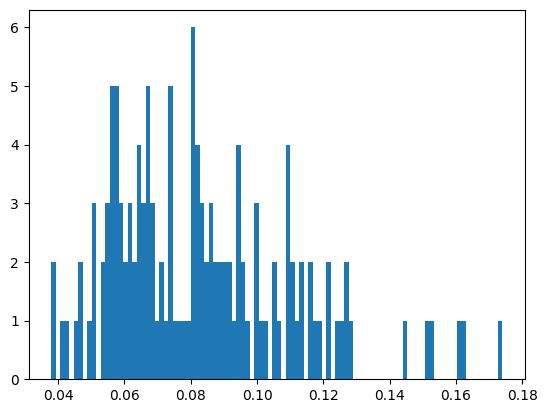

In [108]:
plt.hist(pmax[ypred_labels == 'A0207'], bins = 100)

(array([  4.,  19.,  41.,  47.,  76.,  83., 134., 111., 118., 132., 116.,
        112.,  99., 107.,  84.,  87.,  90.,  87.,  84.,  74.,  84.,  73.,
         56.,  56.,  45.,  40.,  40.,  38.,  35.,  35.,  31.,  30.,  25.,
         26.,  25.,  14.,  20.,  14.,  15.,  16.,  12.,  13.,  10.,  15.,
         13.,   7.,  13.,   6.,   3.,  10.,   5.,   9.,   1.,   2.,   3.,
          5.,  10.,   2.,   4.,   2.,   4.,   3.,   3.,   2.,   3.,   0.,
          1.,   1.,   0.,   2.,   2.,   2.,   1.,   1.,   2.,   2.,   1.,
          2.,   0.,   0.,   1.,   1.,   0.,   0.,   0.,   0.,   1.,   0.,
          1.,   0.,   1.,   1.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,
          2.]),
 array([0.02963434, 0.03410115, 0.03856796, 0.04303478, 0.04750159,
        0.0519684 , 0.05643522, 0.06090203, 0.06536885, 0.06983566,
        0.07430247, 0.07876928, 0.0832361 , 0.08770291, 0.09216972,
        0.09663653, 0.10110335, 0.10557017, 0.11003698, 0.11450379,
        0.1189706 , 0.12343742, 0.12790424, 0.

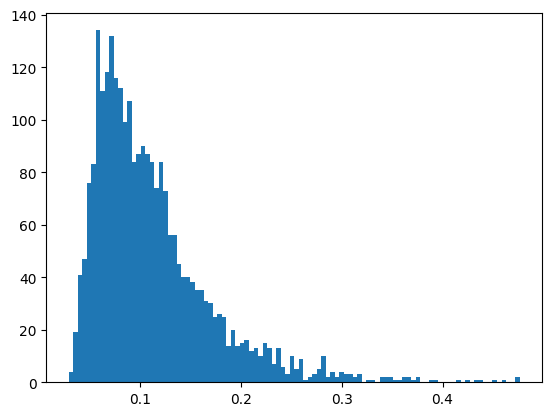

In [99]:
plt.hist(pmax[ypred_labels == 'A0101'], bins = 100)

In [66]:
joblib.dump(pmax, file_path + '_null_distrib.joblib')

['/Users/halasadi/code/pmhc_methods_tf/internal_data/2023_12_22_test_9mer_xgboost_model_null_distrib.joblib']

In [75]:
def calculate_pval(pred_scores):
    return(np.mean(pmax[:, np.newaxis] > pred_scores, axis=0))

In [84]:
pred_scores = np.array([0.8, 0.5, 0.1])

In [85]:
pvals = calculate_pval(np.array([0.5, 0.5, 0.1]))

In [86]:
el_ranks = 100 * pvals

In [87]:
el_ranks

array([ 3.61 ,  3.61 , 64.444])